<a href="https://colab.research.google.com/github/franmazzaro/7506R-2C2023-GRUPO39/blob/main/7506R_TP1_GRUPO39_CHP4_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, make_scorer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
import warnings

In [28]:
np.random.seed(1)
tf.random.set_seed(1)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [29]:
# Importamos el dataset que trabajamos en el checkpoint 2 con las varibles categóricas como dummies
reservas = pd.read_csv('/content/sample_data/reservas_dummies.csv')

# Importamos el dataset de test con las variables categóricas como dummies
test = pd.read_csv('/content/sample_data/test_dummies.csv')

# Preprocesamiento

In [30]:
# Droppeamos el id para poder entrenar y predecir
ids_train = reservas["id"]
ids_test = test["id"]
reservas.drop(columns="id", inplace=True)
test.drop(columns="id", inplace=True)

# Ordenamos las columnas
reservas = reservas.reindex(sorted(reservas.columns), axis=1)
test = test.reindex(sorted(test.columns), axis=1)

# Imputamos datos faltantes
test['agent'] = test['agent'].fillna(-1)
test['company'] = test['company'].fillna(-1)

In [31]:
def mostrar_metricas(y_test, y_pred):
  #Cantidad de aciertos
  print('correctas: ', np.sum(y_test == y_pred))
  print('total: ', len(y_test))

  print(classification_report(y_test, y_pred))

  #Grafico la matriz de confusión
  tabla=confusion_matrix(y_test, y_pred)
  sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

In [32]:
def exportar_prediccion(ids_test, y_pred, filename):
  prediccion = pd.DataFrame({"id": ids_test, "is_canceled": y_pred})
  prediccion.to_csv('/content/sample_data/prediccion_'+filename+'.csv', index = False)

In [33]:
a = reservas.drop(['is_canceled'], axis=1)
b = reservas['is_canceled']

In [34]:
# Normalización Min-Max en los datos de entrenamiento
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(a)

# Balanceo de clases
class_0 = X_train_normalized[b == 0]
class_1 = X_train_normalized[b == 1]

# Balanceo de clases (sobremuestreo de la clase minoritaria)

# Selecciona los ejemplos de la clase mayoritaria (clase "0")
class_0 = X_train_normalized[b == 0]

# Selecciona los ejemplos de la clase minoritaria (clase "1")
class_1 = X_train_normalized[b == 1]

# Realiza sobremuestreo de la clase minoritaria (clase "1")
# - replace=True: Permite muestrear con reemplazo
# - n_samples=len(class_0): Genera tantas muestras de la clase "1" como ejemplos de la clase "0"
class_0_oversampled = resample(class_1, replace=True, n_samples=len(class_0), random_state=42)

# Combina los datos equilibrados en X_train_balanced y y_train_balanced
# - np.vstack: Apila verticalmente los arrays
# - np.hstack: Concatena horizontalmente los arrays
X_train_balanced = np.vstack((class_0, class_0_oversampled))
y_train_balanced = np.hstack((b[b == 0], np.ones(len(class_0))))

In [35]:
# Datos con normalización y balanceo
x_train_bal, x_test_bal, y_train_bal, y_test_bal = train_test_split(X_train_balanced, y_train_balanced, test_size=0.20, random_state=0)
print(y_test_bal)

test_bal  = scaler.transform(test)

[1. 1. 1. ... 0. 0. 0.]


# Modelos de Redes Neuronales

## Definimos la Arquitectura

Utilizamos la funcion de activacion sigmoid para nuestro modelo, ya que como estamos en una prediccion de clasificacion binaria, esta funcion va entre 0 y 1

Colocamos una capa  oculta de 300 neuronas para probar, y utilizamos un tipo de conexion Dropout que es de regularizacion. Apaga neuronas para evitar overfitting.

In [36]:
cant_clases=len(np.unique(y_train_bal))
print(cant_clases)
d_in=len(a.columns)
print(d_in)
modelo_1 = keras.Sequential([
    keras.layers.Dense(1,input_shape=(d_in,), activation='sigmoid'),
    keras.layers.Dense(300, activation='sigmoid'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')])

modelo_1.summary()

2
213
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 1)                 214       
                                                                 
 dense_10 (Dense)            (None, 300)               600       
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 301       
                                                                 
Total params: 1115 (4.36 KB)
Trainable params: 1115 (4.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Probamos creando un modelo con una neurona de entrada, luego 213 neuronas que es igual a la cantidad de columnas de nuestro modelo, una funcion de regularizacion que apaga neuronas para reducir el overfitting y por ultimo una neurona de salida ya que es una clasificacion binaria.

Elegimos 213 basandonos en un articulo que recomendaba esta configuracion para problemas de clasificacion binaria (https://medium.com/geekculture/introduction-to-neural-network-2f8b8221fbd3)

In [37]:
cant_clases=len(np.unique(y_train_bal))
print(cant_clases)
d_in=len(a.columns)
print(d_in)
modelo_2 = keras.Sequential([
    keras.layers.Dense(1,input_shape=(d_in,), activation='sigmoid'),
    keras.layers.Dense(213, activation='sigmoid'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')])

modelo_2.summary()

2
213
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1)                 214       
                                                                 
 dense_13 (Dense)            (None, 213)               426       
                                                                 
 dropout_1 (Dropout)         (None, 213)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 214       
                                                                 
Total params: 854 (3.34 KB)
Trainable params: 854 (3.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Aumentamos la cantidad de neuronas a 500 para probar y sumamos otra capa

In [72]:
cant_clases=len(np.unique(y_train_bal))
print(cant_clases)
d_in=len(a.columns)
print(d_in)
modelo_3 = keras.Sequential([
    keras.layers.Dense(1,input_shape=(d_in,), activation='sigmoid'),
    keras.layers.Dense(500, activation='sigmoid'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(500, activation='sigmoid'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')])

modelo_3.summary()

2
213
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 1)                 214       
                                                                 
 dense_40 (Dense)            (None, 500)               1000      
                                                                 
 dropout_9 (Dropout)         (None, 500)               0         
                                                                 
 dense_41 (Dense)            (None, 500)               250500    
                                                                 
 dropout_10 (Dropout)        (None, 500)               0         
                                                                 
 dense_42 (Dense)            (None, 1)                 501       
                                                                 
Total params: 252215 (985.21 KB)
Trainable para

## Definimos el Optimizador y entrenamos

Definimos el optimizador, probamos usando Nadam ya que es adam mas nesterov y converge mas rapido que adam a menudo.


Agregamos learning_rate = 0.001 y usamos loss = binary_crossentropy ya que estamos en un problema de clasificacion binario.

In [39]:
modelo_1.compile(
  optimizer=keras.optimizers.Nadam(learning_rate=0.001),
  loss='binary_crossentropy',
  metrics=['AUC'],
)

cant_epochs=40
modelo_1_historia = modelo_1.fit(x_train_bal,y_train_bal,
                                                epochs=cant_epochs,
                                                batch_size=50,verbose=False)

In [40]:
modelo_2.compile(
  optimizer=keras.optimizers.Nadam(learning_rate=0.001),
  loss='binary_crossentropy',
  metrics=['AUC'],
)

cant_epochs=40
modelo_2_historia = modelo_2.fit(x_train_bal,y_train_bal,
                                                epochs=cant_epochs,
                                                batch_size=50,verbose=False)

In [73]:
modelo_3.compile(
  optimizer=keras.optimizers.Nadam(learning_rate=0.001),
  loss='binary_crossentropy',
  metrics=['AUC'],
)

cant_epochs=40
modelo_3_historia = modelo_3.fit(x_train_bal,y_train_bal,
                                                epochs=cant_epochs,
                                                batch_size=50,verbose=False)

## Matrices de Counfusion

MODELO 1

369/369 [==============================] - 1s 2ms/step
correctas:  69572186
total:  11794
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      5781
           1       0.80      0.80      0.80      6013

    accuracy                           0.80     11794
   macro avg       0.80      0.80      0.80     11794
weighted avg       0.80      0.80      0.80     11794



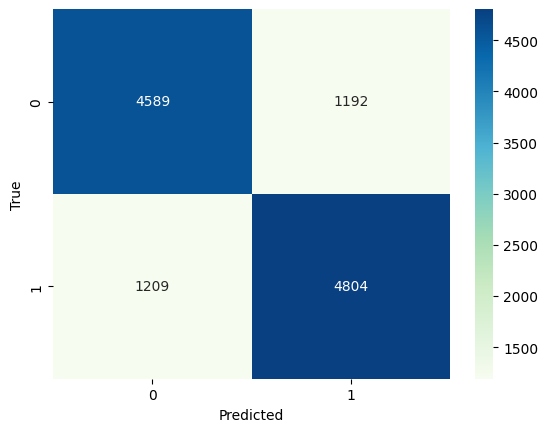

In [43]:
y_predic_1 = modelo_1.predict(x_test_bal)
y_predic_cat_1 = np.where(y_predic_1>0.5,1,0)
mostrar_metricas(y_predic_cat_1, y_test_bal)

MODELO 2

369/369 [==============================] - 1s 2ms/step
correctas:  69567632
total:  11794
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      5804
           1       0.80      0.80      0.80      5990

    accuracy                           0.80     11794
   macro avg       0.80      0.80      0.80     11794
weighted avg       0.80      0.80      0.80     11794



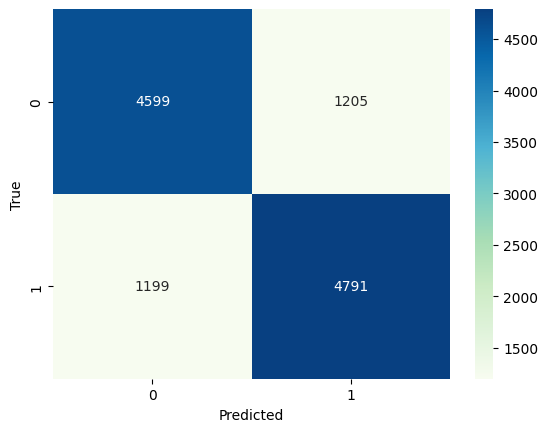

In [44]:
y_predic_2 = modelo_2.predict(x_test_bal)
y_predic_cat_2 = np.where(y_predic_2>0.5,1,0)
mostrar_metricas(y_predic_cat_2, y_test_bal)

MODELO 3

369/369 [==============================] - 1s 3ms/step
correctas:  69633170
total:  11794
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      5473
           1       0.83      0.79      0.81      6321

    accuracy                           0.80     11794
   macro avg       0.80      0.80      0.80     11794
weighted avg       0.80      0.80      0.80     11794



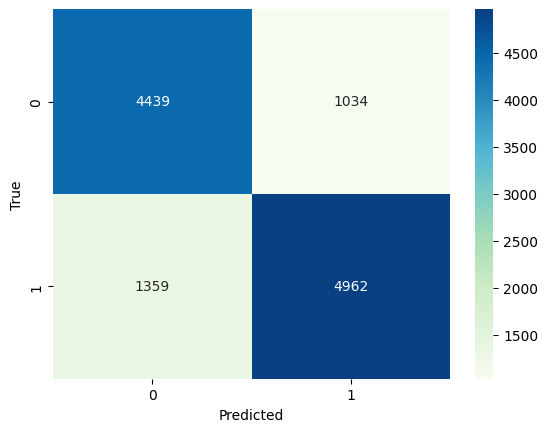

In [75]:
y_predic_3 = modelo_3.predict(x_test_bal)
y_predic_cat_3 = np.where(y_predic_3>0.5,1,0)
mostrar_metricas(y_predic_cat_3, y_test_bal)

Como se muestra en los graficos podemos ver que a pesar de variar la cantidad de neuronas y capas los resultados son bastante similares. Optamos por elegir el modelo numero 2 por requerir menor capacidad computacional y al no tener un elevado numero de neuronas no corremos riesgo de overfitting.



## Graficos

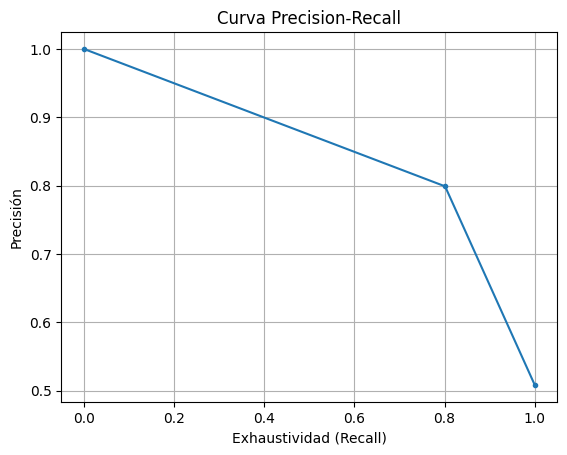

In [46]:
import matplotlib.pyplot as plt
precision, recall, thresholds = precision_recall_curve(y_test_bal, y_predic_cat_1)


plt.plot(recall, precision, marker='.')
plt.xlabel('Exhaustividad (Recall)')
plt.ylabel('Precisión')
plt.title('Curva Precision-Recall')
plt.grid(True)
plt.show()

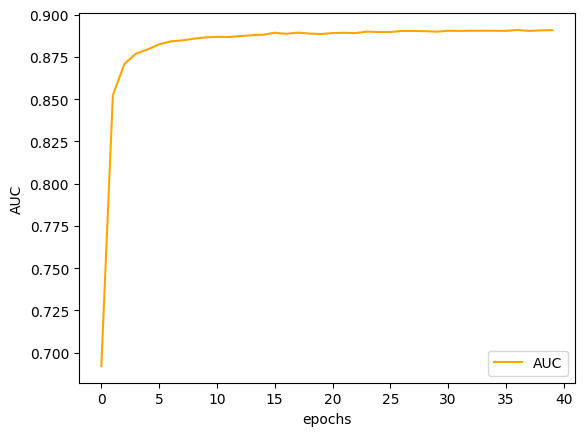

In [47]:
epochs = range(cant_epochs)

plt.plot(epochs, modelo_1_historia.history['auc'], color='orange', label='AUC')
plt.xlabel("epochs")
plt.ylabel("AUC")
plt.legend()

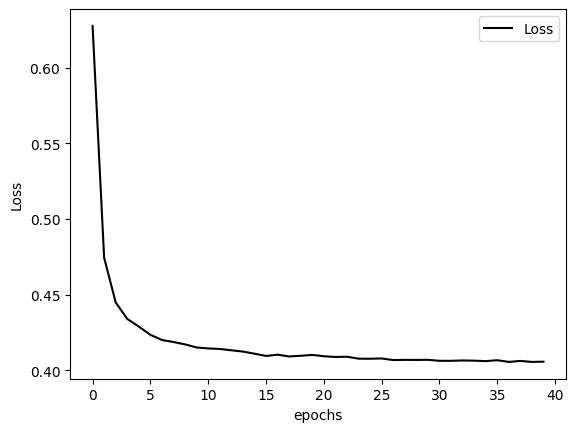

In [48]:
epochs = range(cant_epochs)

plt.plot(epochs, modelo_1_historia.history['loss'], color='black', label='Loss')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()

## Optimizacion de hiperparametros

Probamos la funcion de activacion relu y tanh

In [80]:
cant_clases=len(np.unique(y_train_bal))
print(cant_clases)
d_in=len(a.columns)
print(d_in)
modelo_2 = keras.Sequential([
    keras.layers.Dense(1,input_shape=(d_in,), activation='relu'),
    keras.layers.Dense(213, activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')])

modelo_2.summary()

2
213
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 1)                 214       
                                                                 
 dense_47 (Dense)            (None, 213)               426       
                                                                 
 dropout_12 (Dropout)        (None, 213)               0         
                                                                 
 dense_48 (Dense)            (None, 1)                 214       
                                                                 
Total params: 854 (3.34 KB)
Trainable params: 854 (3.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [81]:
modelo_2.compile(
  optimizer=keras.optimizers.Nadam(learning_rate=0.001),
  loss='binary_crossentropy',
  metrics=['AUC'],
)

cant_epochs=40
modelo_2_historia = modelo_2.fit(x_train_bal,y_train_bal,
                                                epochs=cant_epochs,
                                                batch_size=50,verbose=False)

369/369 [==============================] - 1s 3ms/step
correctas:  69544466
total:  11794
              precision    recall  f1-score   support

           0       0.80      0.79      0.79      5921
           1       0.79      0.80      0.80      5873

    accuracy                           0.79     11794
   macro avg       0.80      0.79      0.79     11794
weighted avg       0.80      0.79      0.79     11794



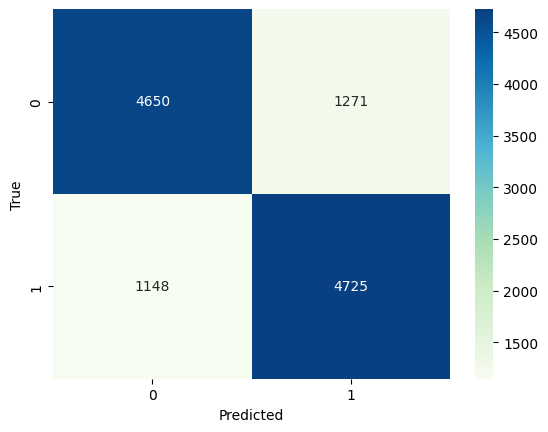

In [82]:
y_predic_2 = modelo_2.predict(x_test_bal)
y_predic_cat_2 = np.where(y_predic_2>0.5,1,0)
mostrar_metricas(y_predic_cat_2, y_test_bal)

Podemos observar que con tanh y relu no hay diferencias significativas.

Procedemos a usar solo relu

In [86]:
cant_clases=len(np.unique(y_train_bal))
print(cant_clases)
d_in=len(a.columns)
print(d_in)
modelo_2 = keras.Sequential([
    keras.layers.Dense(1,input_shape=(d_in,), activation='relu'),
    keras.layers.Dense(106, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')])

modelo_2.summary()

2
213
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_53 (Dense)            (None, 1)                 214       
                                                                 
 dense_54 (Dense)            (None, 106)               212       
                                                                 
 dropout_15 (Dropout)        (None, 106)               0         
                                                                 
 dense_55 (Dense)            (None, 1)                 107       
                                                                 
Total params: 533 (2.08 KB)
Trainable params: 533 (2.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [87]:
modelo_2.compile(
  optimizer=keras.optimizers.Nadam(learning_rate=0.001),
  loss='binary_crossentropy',
  metrics=['AUC'],
)

cant_epochs=40
modelo_2_historia = modelo_2.fit(x_train_bal,y_train_bal,
                                                epochs=cant_epochs,
                                                batch_size=50,verbose=False)

369/369 [==============================] - 1s 2ms/step
correctas:  69645842
total:  11794
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      5409
           1       0.83      0.78      0.81      6385

    accuracy                           0.80     11794
   macro avg       0.80      0.80      0.80     11794
weighted avg       0.80      0.80      0.80     11794



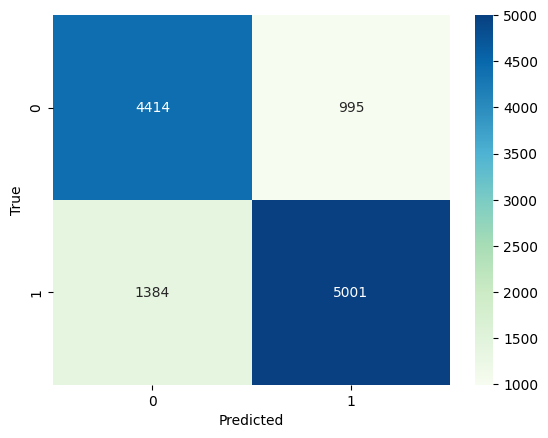

In [89]:
y_predic_2 = modelo_2.predict(x_test_bal)
y_predic_cat_2 = np.where(y_predic_2>0.5,1,0)
mostrar_metricas(y_predic_cat_2, y_test_bal)

Debido a que vemos un bajo incremento en las metricas elegimos este modelo para realizar nuestras predicciones.

# Exportar

In [90]:
y_pred_ = modelo_2.predict(test_bal)
y_pred = np.where(y_pred_ > 0.5, 1, 0).astype(int)

830/830 [==============================] - 2s 3ms/step


In [91]:
y_pred = y_pred.reshape(-1)

In [92]:
exportar_prediccion(ids_test, y_pred, "redes_neuronales_2")